In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cài đặt các thư viện cần thiết
!pip install --quiet underthesea rouge-score scikit-learn networkx

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.4/978.4 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.2 MB/s eta 0:00:00


In [ ]:
# Import thư viện
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import networkx as nx
import numpy as np
from bs4 import BeautifulSoup
from rouge_score import rouge_scorer
from underthesea import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# --- CẤU HÌNH ĐƯỜNG DẪN ---
# Bạn hãy kiểm tra lại đường dẫn file json và stopwords của bạn
json_file_path = "/content/drive/MyDrive/dataset/dataset_dantri_clean.json"
stopwords_file_path = "/content/drive/MyDrive/dataset/Vietnamese-stopwords.txt"


In [ ]:
# --- 1. HÀM HỖ TRỢ ĐỌC DỮ LIỆU ---
def load_data(path):
    try:
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            # Lọc chỉ lấy các mục có content và description
            return [{'content': item['content'], 'reference_summary': item['description']}
                    for item in data if 'content' in item and 'description' in item]
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file '{path}'.")
    except Exception as e:
        print(f"Lỗi khi đọc file JSON: {e}")
    return []

In [ ]:
def get_stopwords(path):
    try:
        with open(path, 'r', encoding="utf-8") as f:
            # Trả về list để dùng cho TfidfVectorizer
            return [m.strip().lower() for m in f.readlines()]
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file stopwords '{path}'.")
        return []

# Tải stopwords vào bộ nhớ
cached_stopwords = get_stopwords(stopwords_file_path)

In [ ]:
# --- 2. THUẬT TOÁN TEXTRANK (CORE LOGIC MỚI) ---

def textrank_summarize(text, top_n=3):
    """
    Tóm tắt văn bản sử dụng TextRank và TF-IDF.
    Args:
        text (str): Văn bản gốc.
        top_n (int): Số lượng câu muốn trích xuất làm tóm tắt.
    Returns:
        str: Văn bản tóm tắt.
    """
    # 1. Tách câu (Sử dụng underthesea để tách câu tiếng Việt chuẩn hơn)
    sentences = sent_tokenize(text)

    # Nếu văn bản quá ngắn (ít hơn số câu cần tóm tắt), trả về nguyên văn
    if len(sentences) <= top_n:
        return text

    # 2. Tiền xử lý dữ liệu cho TF-IDF
    # Tách từ cho từng câu để tạo corpus (bộ ngữ liệu)
    # Ví dụ: "Hôm nay trời đẹp" -> "Hôm_nay trời đẹp" (nhờ underthesea)
    corpus = [" ".join(word_tokenize(s)) for s in sentences]

    # 3. Vector hóa văn bản (TF-IDF)
    # Loại bỏ stopwords tiếng Việt trong quá trình này
    try:
        vectorizer = TfidfVectorizer(stop_words=cached_stopwords)
        tfidf_matrix = vectorizer.fit_transform(corpus)
    except ValueError:
        # Trường hợp văn bản toàn stopwords hoặc rỗng
        return sentences[0]

    # 4. Tính ma trận tương đồng (Cosine Similarity) giữa các câu
    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # 5. Xây dựng đồ thị và tính điểm PageRank
    # Mỗi câu là 1 nút, độ tương đồng là trọng số cạnh
    nx_graph = nx.from_numpy_array(similarity_matrix)

    try:
        scores = nx.pagerank(nx_graph, max_iter=500) # Tăng max_iter để đảm bảo hội tụ
    except nx.PowerIterationFailedConvergence:
        # Nếu không hội tụ, chọn ngẫu nhiên hoặc chọn câu đầu
        return " ".join(sentences[:top_n])

    # 6. Xếp hạng câu
    # Tạo danh sách (điểm số, nội dung câu, chỉ số index gốc)
    ranked_sentences = sorted(((scores[i], s, i) for i, s in enumerate(sentences)), reverse=True)

    # 7. Chọn top_n câu có điểm cao nhất
    selected_sentences = ranked_sentences[:top_n]

    # 8. Sắp xếp lại các câu theo thứ tự xuất hiện trong bài gốc
    # Điều này giúp bản tóm tắt đọc trôi chảy, logic hơn
    selected_sentences.sort(key=lambda x: x[2]) # Sắp xếp theo index (phần tử thứ 3)

    # Ghép lại thành đoạn văn
    summary = " ".join([s for _, s, _ in selected_sentences])
    return summary

In [ ]:
# --- 3. QUY TRÌNH ĐÁNH GIÁ & VẼ BIỂU ĐỒ ---

def run_evaluation_and_plot():
    # Load dữ liệu
    data = load_data(json_file_path)
    if not data:
        print("Không có dữ liệu để xử lý.")
        return

    # Khởi tạo bộ chấm điểm ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

    # Chọn 4 bài ngẫu nhiên
    samples = random.sample(data, 4) if len(data) >= 4 else data

    # Thiết lập biểu đồ
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Đánh giá hiệu suất TextRank trên {len(samples)} bài ngẫu nhiên', fontsize=16)

    print(f"Đang xử lý {len(samples)} bài viết...\n")

    for i, (item, ax) in enumerate(zip(samples, axes.flatten())):
        original_text = item['content']
        ref_summary = item['reference_summary']

        # Chạy tóm tắt bằng TextRank
        # top_n=3 nghĩa là chọn 3 câu quan trọng nhất. Bạn có thể chỉnh số này.
        gen_summary = textrank_summarize(original_text, top_n=3)

        # Tính điểm ROUGE
        scores = scorer.score(ref_summary, gen_summary)

        # Lấy dữ liệu để vẽ
        metrics = ['rouge1', 'rouge2', 'rougeL']
        values = [scores[m].fmeasure for m in metrics]

        # Vẽ biểu đồ cột
        sns.barplot(x=metrics, y=values, ax=ax, palette="viridis", hue=metrics, legend=False)
        ax.set_title(f"Bài viết #{i+1}", fontsize=12, fontweight='bold')
        ax.set_ylim(0, 1.0) # ROUGE score thang từ 0 đến 1
        ax.grid(axis='y', linestyle='--', alpha=0.5)

        # Hiển thị giá trị cụ thể trên cột
        for j, v in enumerate(values):
            ax.text(j, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

        # In ra màn hình để kiểm tra văn bản (nếu muốn)
        print(f"--- Bài {i+1} ---")
        print(f"Gốc ({len(original_text)} chars) -> Tóm tắt ({len(gen_summary)} chars)")
        print(f"ROUGE-1: {scores['rouge1'].fmeasure:.3f}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Đang xử lý 4 bài viết...



/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bao', 'bay', 'biến', 'biệt', 'bây', 'bõm', 'bảo', 'bất', 'bẩy', 'bập', 'bắt', 'bội', 'chao', 'chi', 'chia', 'chu', 'chui', 'chuẩn', 'chà', 'chành', 'chí', 'chót', 'chùn', 'chăn', 'chũn', 'chưng', 'chạnh', 'chả', 'chầm', 'chầy', 'chập', 'chắn', 'chẳng', 'chết', 'chốc', 'chừ', 'chừng', 'coi', 'cu', 'cá', 'câu', 'cóc', 'công', 'cạnh', 'cảm', 'cầu', 'cật', 'cắt', 'cổ', 'cụ', 'cục', 'cực', 'da', 'dà', 'dĩ', 'dưng', 'dần', 'dầu', 'dịp', 'dở', 'dụng', 'gian', 'giá', 'giác', 'giời', 'ha', 'hiện', 'hoàn', 'hèn', 'hình', 'hô', 'hầu', 'hậu', 'hẳn', 'hồ', 'hỗ', 'hội', 'hợp', 'hự', 'khói', 'khô', 'khăn', 'khắc', 'khẳng', 'kia', 'kiện', 'kê', 'kì', 'kìa', 'kỳ', 'lai', 'le', 'liên', 'liệt', 'loạt', 'luận', 'luật', 'luốt', 'lình', 'lí', 'lô', 'lý', 'lập', 'lẽ', 'lị', 'lự', 'lực', 'mày', 'mòi', 'mù', 'mạng'

--- Bài 1 ---
Gốc (3372 chars) -> Tóm tắt (570 chars)
ROUGE-1: 0.319
--- Bài 2 ---
Gốc (2138 chars) -> Tóm tắt (1069 chars)
ROUGE-1: 0.220


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bao', 'bay', 'biến', 'biệt', 'bây', 'bõm', 'bảo', 'bất', 'bẩy', 'bập', 'bắt', 'bội', 'chao', 'chi', 'chia', 'chu', 'chui', 'chuẩn', 'chà', 'chành', 'chí', 'chót', 'chùn', 'chăn', 'chũn', 'chưng', 'chạnh', 'chả', 'chầm', 'chầy', 'chập', 'chắn', 'chẳng', 'chết', 'chốc', 'chừ', 'chừng', 'coi', 'cu', 'cá', 'câu', 'cóc', 'công', 'cạnh', 'cảm', 'cầu', 'cật', 'cắt', 'cổ', 'cụ', 'cục', 'cực', 'da', 'dà', 'dĩ', 'dưng', 'dần', 'dầu', 'dịp', 'dở', 'dụng', 'gian', 'giá', 'giác', 'giời', 'ha', 'hiện', 'hoàn', 'hèn', 'hình', 'hô', 'hầu', 'hậu', 'hẳn', 'hồ', 'hỗ', 'hội', 'hợp', 'hự', 'khói', 'khô', 'khăn', 'khắc', 'khẳng', 'kia', 'kiện', 'kê', 'kì', 'kìa', 'kỳ', 'lai', 'le', 'liên', 'liệt', 'loạt', 'luận', 'luật', 'luốt', 'lình', 'lí', 'lô', 'lý', 'lập', 'lẽ', 'lị', 'lự', 'lực', 'mày', 'mòi', 'mù', 'mạng'

--- Bài 3 ---
Gốc (1552 chars) -> Tóm tắt (1552 chars)
ROUGE-1: 0.156
--- Bài 4 ---
Gốc (2391 chars) -> Tóm tắt (847 chars)
ROUGE-1: 0.257


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bao', 'bay', 'biến', 'biệt', 'bây', 'bõm', 'bảo', 'bất', 'bẩy', 'bập', 'bắt', 'bội', 'chao', 'chi', 'chia', 'chu', 'chui', 'chuẩn', 'chà', 'chành', 'chí', 'chót', 'chùn', 'chăn', 'chũn', 'chưng', 'chạnh', 'chả', 'chầm', 'chầy', 'chập', 'chắn', 'chẳng', 'chết', 'chốc', 'chừ', 'chừng', 'coi', 'cu', 'cá', 'câu', 'cóc', 'công', 'cạnh', 'cảm', 'cầu', 'cật', 'cắt', 'cổ', 'cụ', 'cục', 'cực', 'da', 'dà', 'dĩ', 'dưng', 'dần', 'dầu', 'dịp', 'dở', 'dụng', 'gian', 'giá', 'giác', 'giời', 'ha', 'hiện', 'hoàn', 'hèn', 'hình', 'hô', 'hầu', 'hậu', 'hẳn', 'hồ', 'hỗ', 'hội', 'hợp', 'hự', 'khói', 'khô', 'khăn', 'khắc', 'khẳng', 'kia', 'kiện', 'kê', 'kì', 'kìa', 'kỳ', 'lai', 'le', 'liên', 'liệt', 'loạt', 'luận', 'luật', 'luốt', 'lình', 'lí', 'lô', 'lý', 'lập', 'lẽ', 'lị', 'lự', 'lực', 'mày', 'mòi', 'mù', 'mạng'

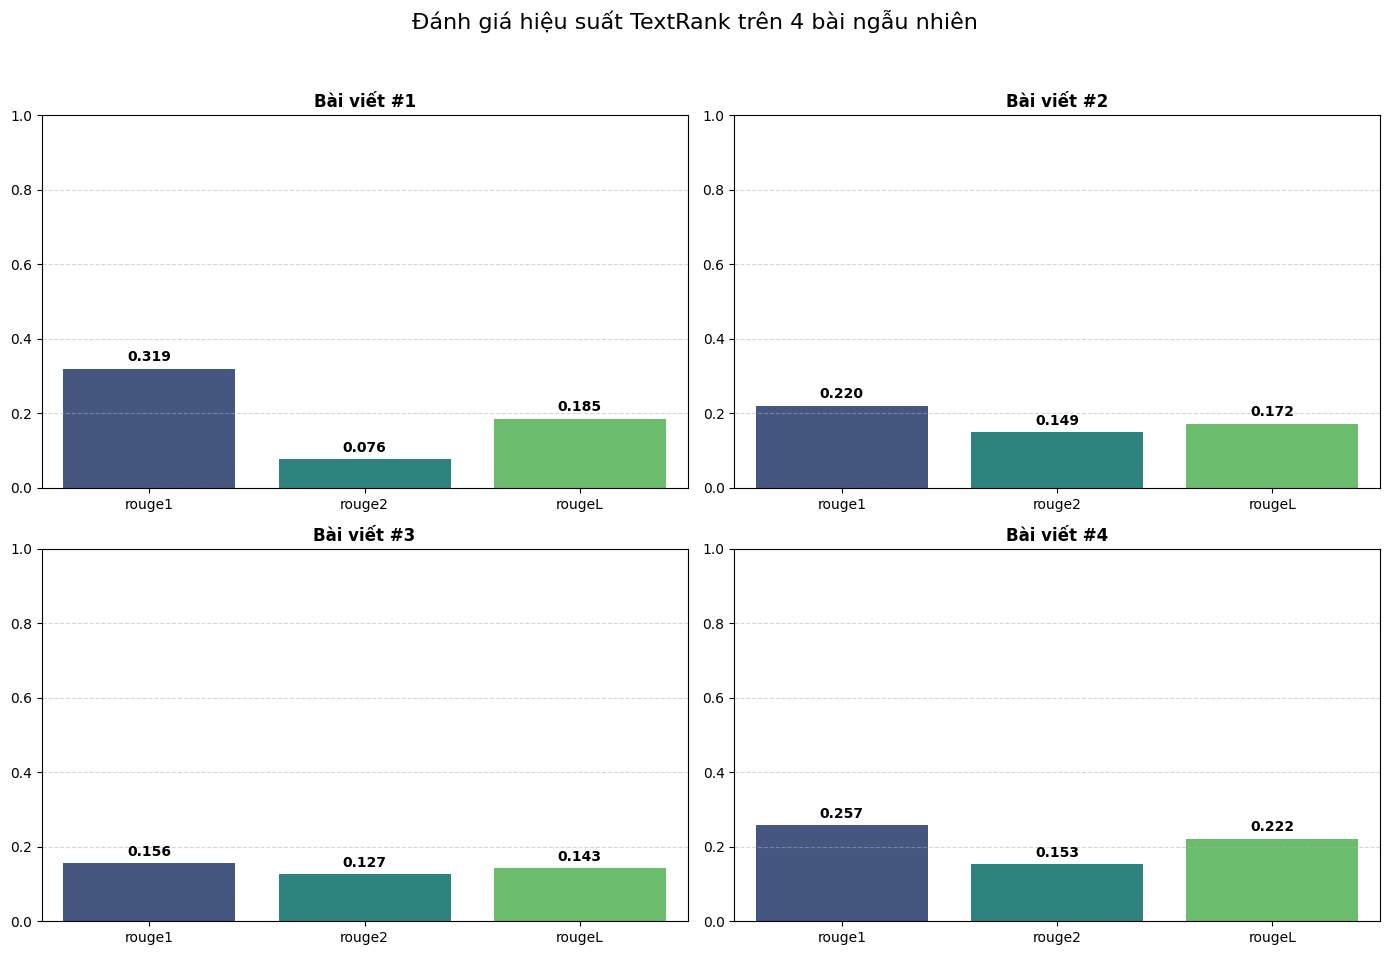

In [ ]:
run_evaluation_and_plot()

In [ ]:
# --- 4. HÀM TEST RIÊNG LẺ (Như yêu cầu của bạn) ---
def summarize_new_text_demo(new_text):
    # Xử lý sơ bộ văn bản đầu vào (clean nhẹ)
    new_text = re.sub(r'\(?\[?(Ảnh|Video|Clip)\s*:[^)]+[\)\]]?', '', new_text, flags=re.IGNORECASE)
    new_text = re.sub(r'\n[A-ZÁÀẢÃẠÂĂÊÔƠƯĐ\s\.]{2,40}$', '', new_text.strip(), flags=re.MULTILINE)
    new_text = re.sub(r'\s+', ' ', new_text).strip()

    print("\n========== DEMO TÓM TẮT VĂN BẢN MỚI ==========")
    print(f"Độ dài gốc: {len(new_text)} ký tự.")

    # Gọi hàm TextRank
    summary = textrank_summarize(new_text, top_n=3)

    print("\n--- KẾT QUẢ TÓM TẮT (TEXTRANK) ---")
    return summary

In [ ]:
if __name__ == "__main__":
    test_article = """
    Sự kiện do Khối phụ trách đào tạo và trải nghiệm sinh viên Đại học RMIT Việt Nam tổ chức,
    thu hút hàng trăm đại biểu từ khắp Đông Nam Á và nhiều quốc gia khác, bao gồm diễn giả từ Đại học Công nghệ Sydney,
    Đại học RMIT Australia. Câu hỏi trọng tâm xuyên suốt hội thảo là \"Làm thế nào để đổi mới giáo dục thực sự cải thiện
    trải nghiệm học tập của sinh viên?\".\n\nHội thảo chia sẻ các sáng kiến đổi mới thực tiễn từ AI trong giáo dục đến học
    tập bao hàm và hợp tác với doanh nghiệp. Ảnh: RMIT\n\nHội thảo Tầm nhìn giáo dục đại học 2025 giới thiệu nhiều cách
    tiếp cận có tính kết nối, từ thiết kế học tập và khả năng tiếp cận đến công nghệ mới nổi, hợp tác với doanh nghiệp
    nhằm nâng cao kết quả học tập của sinh viên. Người tham dự có cơ hội trải nghiệm các dự án thực tế, nguyên mẫu đang
    được triển khai và những chiến lược đã kiểm chứng bằng thực tiễn, từng bước thay đổi các lớp học trên khắp khu vực.
    \n\nTích hợp Gen AI có chủ đích và liêm chính\n\nMột trong những điểm nhấn của hội thảo là bài tham luận chính của
    Phó giáo sư Amanda White đến từ Đại học Công nghệ Sydney (UTS). Là một nhà giáo có tầm ảnh hưởng từng nhận giải
    thưởng quốc gia về giảng dạy đại học tại Australia, bà đã đem đến góc nhìn toàn diện về việc tích hợp AI tạo sinh
    (Gen AI) có chiến lược vào giáo dục đại học.\n\n\"Gen AI là công cụ mạnh mẽ, nhưng giống như một chiếc đồng hồ thông minh,
    nên được sử dụng một cách chiến lược, không phải lúc nào cũng đem ra dùng. Chúng ta cần nghĩ xem đưa Gen AI vào đâu trong
    hệ thống giáo dục là phù hợp\", bà nói.\n\nPhó giáo sư White kêu gọi những người làm công tác giáo dục hướng dẫn để sinh viên
    dùng AI như công cụ hỗ trợ thay vì phụ thuộc. Bà trích lời của Giáo sư Angela Duckworth, tác giả sách Grit: Vững tâm
    bền chí ắt thành công, trong bài phát biểu dành cho tân khoa khóa 2025 của trường Sư phạm Sau đại học thuộc
    Đại học Pennsylvania (Penn GSE): \"Tôi lo rằng sinh viên sẽ dùng AI như một chiếc nạng. Tôi lo rằng vì não bộ
    con người giống như một nhóm cơ, sinh viên phải dùng thì nó mới săn chắc phát triển, nếu không dùng nó sẽ mất dần đi\".
    \n\nPhó giáo sư Amanda White từ Đại học Công nghệ Sydney (Australia) chia sẻ kinh nghiệm áp dụng Gen AI một cách chiến
    lược vào giáo dục đại học. Ảnh: RMIT\n\nCùng đề tài, bà đề cập thêm đến những nỗi lo và hiểu lầm phổ biến quanh Gen AI,
    từ việc lo ngại sản phẩm do công nghệ này tạo ra bị xem là gian lận đến hiện tượng \"AI slop\", rác do AI tạo ra trong các bài tập,
    cũng như những ý kiến kêu gọi cấm hoàn toàn trong giáo dục.\n\nPhó giáo sư White đề xuất một khung tích hợp Gen AI
    có mục tiêu rõ ràng trong giáo dục. Khung này gồm ba phần: minh bạch và niềm tin; gắn kết với kết quả học tập;
    công bằng và khả năng tiếp cận. Trong đó, minh bạch, niềm tin cần truyền thông rõ ràng về việc AI được dùng khi
    nào và như thế nào. Theo bà, việc gắn kết với kết quả học tập đảm bảo các công cụ AI sẽ hỗ trợ phát triển kỹ năng,
    thay vì thay thế. Đồng thời, nữ diễn giả nêu bật tầm quan trọng của sự công bằng và khả năng tiếp cận của việc biến
    AI thành công cụ hữu ích cho tất cả người học, kể cả những người có nhu cầu học tập đa dạng.\n\nBà dùng lớp kế toán
    dành cho sinh viên năm nhất tại UTS làm ví dụ minh chứng cho việc ứng dụng khung hành động này vào thực tế giảng dạy.
    Với hơn 1.800 sinh viên, Phó giáo sư White thiết kế lại bài viết tổng kết trải nghiệm cá nhân dùng công cụ Gen AI.
    Qua đó, sinh viên có thể tương tác sâu hơn với nội dung học và cải thiện kết quả, đặc biệt với nhóm có khác biệt
    trong cách học.\n\n\"Người làm giáo dục cần là tấm gương cho sinh viên về sự kiên cường, thấu cảm và tư duy phản biện,
    những kỹ năng mà AI không thể thay thế\", bà nhấn mạnh.\n\nHọc tập hợp tác\n\nBên cạnh tham luận của Phó giáo sư White,
    các đại biểu còn được tham dự vào tám thảo luận chuyên đề được tổ chức song song bởi các nhóm chuyên gia RMIT.
    Trong đó, phiên thảo luận \"Khám phá chân trời AI: Xu hướng hiện tại và tương lai\" của nhóm nghiên cứu
    Tương lai giáo dục đã giới thiệu về những công nghệ khác ngoài ChatGPT, bao gồm các mô hình suy luận,
    công cụ phát hiện deepfake và tích hợp thực tế ảo VR.\n\nSong song, tại phiên thảo luận
    \"Kết nối khả năng tiếp cận và thiết kế học tập\", cô Melanie Casul (Chăm sóc sức khỏe và tâm lý) và
    cô Nguyễn Ngọc Linh (Thiết kế học tập) chia sẻ về trường hợp một sinh viên khiếm thị tại RMIT Việt Nam. Theo đó,
    hai diễn giả chỉ ra rằng kế hoạch học tập đồng thiết kế, kết hợp giữa hỗ trợ của con người và các công cụ số, có thể
    giúp thu hẹp khoảng cách thế giới số đem lại.\n\nTiến sĩ Chu Thanh Tuấn, Phó chủ nhiệm bộ môn đến từ Khoa Kinh doanh,
    cũng dẫn dắt một phiên thảo luận về đổi mới bộ hồ sơ năng lực của sinh viên tốt nghiệp từ ngành Kinh doanh.
    Ông giới thiệu mô hình hợp tác với doanh nghiệp kéo dài suốt học kỳ gồm các kỳ thực tập ngắn và thử thách giải quyết
    các tình huống kinh doanh đang diễn ra trong thực tế, mang đến hướng tiếp cận có thể nhân rộng đối với đồ án cuối khóa
    mang tính thực tiễn.\n\nNhóm chuyên gia đưa ra giá trị của học tập suốt đời, mô hình giảng dạy linh hoạt và không gian
    học tập đồng sáng tạo để phản ánh những thách thức trong thế giới thực. Ảnh: RMIT\n\nNgoài ra, Tầm nhìn giáo dục đại học
    2025 có phiên thảo luận chuyên đề quy tụ các đại diện giới học thuật và doanh nghiệp, gồm: Phó giáo sư Amanda White,
    Phó giáo sư Donna Cleveland (RMIT Việt Nam) và ông Tường Trần (HEX). Phần chia sẻ của các diễn giả nhấn mạnh tầm quan
    trọng của học tập suốt đời, các mô hình học tập đa hình thức và kết hợp, cũng như nhu cầu cùng kiến tạo môi trường học
    tập phản ánh đúng thách thức thực tế.\n\nVới những nội dung trên, hội thảo giới thiệu về những công nghệ mới, đồng thời,
    kêu gọi hành động, khẳng định để đem đến thay đổi thực chất trong giáo dục, cần sự hợp tác, các phương pháp đã được kiểm
    chứng thực tế và cam kết bao hàm, khả năng tiếp cận.\n\nNhật Lệ
    """
summarize_new_text_demo(test_article)


========== DEMO TÓM TẮT VĂN BẢN MỚI ==========
Độ dài gốc: 2972 ký tự.

--- KẾT QUẢ TÓM TẮT (TEXTRANK) ---


'Hội thảo chia sẻ các sáng kiến đổi mới thực tiễn từ AI trong giáo dục đến học tập bao hàm và hợp tác với doanh nghiệp. Là một nhà giáo có tầm ảnh hưởng từng nhận giải thưởng quốc gia về giảng dạy đại học tại Australia, bà đã đem đến góc nhìn toàn diện về việc tích hợp AI tạo sinh (Gen AI) có chiến lược vào giáo dục đại học. Phó giáo sư Amanda White từ Đại học Công nghệ Sydney (Australia) chia sẻ kinh nghiệm áp dụng Gen AI một cách chiến lược vào giáo dục đại học.'